Stochastic Variational Bayes
=======================

This notebook implements Example 1 from the FMRIB tutorial on Variational Bayes II: Stochastic Variational Bayes ("fitting a Gaussian distribution).

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [2]:
import numpy as np

# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 1.0
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[43.22623123 42.3368178  40.86204379 42.57882241 41.1800518  41.34138946
 42.30707524 42.84193671 41.59845803 43.76814113 40.34468881 41.8628961
 40.46699096 42.45399769 41.27497821 40.58240253 42.53662342 40.91713104
 39.6224457  41.69657722 40.94641498 42.14231512 41.88705538 42.76333152
 41.90518663 40.57840825 40.71022059 42.55493213 41.52697501 43.24794491
 41.98710416 41.86170947 41.96417113 41.91766925 42.05185416 43.23786739
 40.72773901 41.70335325 42.02112784 43.50439506 41.78010096 42.86304006
 42.07754453 41.93969479 41.59351494 40.67864637 41.41001942 42.47835157
 41.84107604 41.97401178 42.35821546 43.02788542 42.76272561 40.41650849
 41.68456752 41.22627558 40.54813769 42.21674503 42.53073637 41.06319853
 40.10806698 42.77075044 42.585072   45.4731736  43.08050022 40.95493438
 41.92953711 40.51550758 41.32929814 42.39779034 43.00706362 42.31526745
 41.97617386 41.20226133 41.15797801 42.33123679 41.77873725 41.5295315
 42.84662295 42.62370292 44.0692972

As with analytic Variational Bayes, we need to choose an approximate form for our priors and posteriors. However we have more freedom in the stochastic method since we are not limited by the requirement that the distributions be conjugate with respect to the likelihood. 

We will choose a multivariate normal distribution (MVN) over the two parameters $\mu$ and $log(\frac{1}{\beta}$ for prior and posterior. Inferring the log of the noise variance is useful as it avoid the possibility of negative values during the optimization which would make the likelihood ill-defined.

The choice of an MVN means that we can allow for covariance (correlation) between the noise and signal parameters. This is unlike the analytic case where the posterior had to be factorised over these two parameters.

An MVN distribution for $N$ parameters is defined by a vector of $N$ mean values and an $N \times N$ covariance matrix. For the prior we will use the following values:

$$\textbf{m}_0 = \begin{bmatrix} \mu_0 \\ b_0 \end{bmatrix}$$

$$\textbf{C}_0 = \begin{bmatrix} v_0 & 0 \\ 0 & w_0 \end{bmatrix}$$

Note that we are not assuming any prior covariance. 

We define some suitable relatively uninformative prior values here:

In [3]:
m0 = 0.0
v0 = 100000.0
b0 = 0.0
w0 = 100000.0
print("Priors: P(mu, log(1/beta)) = MVN([%f, %f], [[%f, 0], [0, %f]])" % (m0, v0, b0, w0))

Priors: P(mu, log(1/beta)) = MVN([0.000000, 100000.000000], [[0.000000, 0], [0, 100000.000000]])


Stochastic VB is based around minimising the free energy so we will need to implement the calculation of the free energy. We will be using the TensorFlow framework to perform the minimisation so the calculation must be in terms of tensors (multidimensional arrays). In our case the following constant tensors must be defined (where $N$ is the number of data values we have:

 - Data samples: $[N]$
 - Prior mean: $[2]$
 - Prior covariance: $[2 \times 2]$

We must also define *variable* tensors for the posterior - TensorFlow will allow these to change during the optimization in order to minimise the cost (free energy):

 - Posterior mean: $[2]$
 - Posterior covariance: $[2 \times 2]$

The posterior covariance must be a positive-definite matrix - since the optimizer does not know this, it is possible that invalid values may arise and the optimization will fail. To get around this restriction we build the covariance matrix from its Chlolesky decomposition.

$$\textbf{C} = (\textbf{C}_{chol})^T\textbf{C}_{chol}$$

$\textbf{C}_{chol}$ must have positive diagonal elements, so we define the underlying variables for these elements in terms of the log and then form the full $\textbf{C}_{chol}$ matrix as a sum of the exponentials of the log-diagonal elements, and independent variables for the off-diagonal components.

The code for this is below. Note that we need to define initial values for the posterior variables. It turns out that in the stochastic method it is important that the initial poster variance is not too large so although the prior is not informative, the initial posterior is. 

In [17]:
import tensorflow as tf
import numpy as np
data = tf.constant(DATA, dtype=tf.float32)
prior_means = tf.constant([m0, v0], dtype=tf.float32)
prior_covariance = tf.constant([[v0, 0.0], [0.0, w0]], dtype=tf.float32)

post_means_init = [0.0, 0.0]
post_covariance_init = [[1.0, 0.0], [0.0, 1.0]]

chol_off_diag = tf.Variable([[0, 0], [0, 0]], dtype=tf.float32)
# Comment in this line if you do NOT want to infer parameter covariances
#chol_off_diag = tf.constant([[0, 0], [0, 0]], dtype=tf.float32)

chol_log_diag = tf.Variable(tf.log(tf.diag_part(post_covariance_init)), dtype=tf.float32)
chol_diag = tf.diag(tf.sqrt(tf.exp(chol_log_diag)))
post_covariance_chol = tf.add(chol_diag, tf.matrix_band_part(chol_off_diag, -1, 0))

post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol)
post_means = tf.Variable(post_means_init, dtype=tf.float32)
  

At this point we will show how we actually evaluate calculations in TensorFlow. TensorFlow works by defining a graph of operations, but no calculation actually takes place until you ask it to evaluate a tensor (which might be defined in terms of other tensors or Variables. For example we can evaluate the inital values of our posterior as follows:

In [19]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
print("Initial posterior mean: %s" % sess.run(post_means))
print("Initial posterior covariance:\n%s" % sess.run(post_covariance))

Initial posterior mean: [0. 0.]
Initial posterior covariance:
[[1. 0.]
 [0. 1.]]


The next requirement is to be able to obtain a sample of *predicted* data values from the posterior. In stochastic VB this is used to approximate the integrals in the calculation of the free energy. It is *not* related to the number of data samples we have. Smaller values give quicker calculation, but may result in a noisy, non-convergent optimization. We'll start off with a sample size of 5, but you can change this later if you want.

Note the use of the 'reparameterization trick' to express the samples as the scaling of a fixed MVN distribution - this improves the ability of the optimizer to choose better values for the next iteration.

In [20]:
# Number of samples from the posterior
S=5

# eps is a sample from a Gaussian with mean 0 and variance 1
eps = tf.random_normal((2, S), 0, 1, dtype=tf.float32)

# Start off each sample with the current posterior mean
# post_samples is now a tensor of shape [2, n_samples]
samples = tf.tile(tf.reshape(post_means, [2, 1]), [1, S])

# Now add the random sample scaled by the covariance
post_samples = tf.add(samples, tf.matmul(post_covariance_chol, eps))


Let's see how this works by evaluating a sample on our initial posterior

In [21]:
print(sess.run(post_samples))

[[-1.5682673  -0.75988466 -0.35073212  1.1329566  -1.4320179 ]
 [ 1.0423214   1.7318497  -1.0618104   0.6688784   0.77698076]]


Note that we have 5 samples for each of the two parameters - the top row are samples values for $\mu$ and the bottom row are samples of the noise log variance $-\log{\beta}$.

Next we need to implement the free energy calculation. This is the sum of the reconstruction loss (the extent to which the posterior matches the data) and the latent loss (the extent to which the posterior matches the prior). Let's do the reconstruction loss first which is the expected value of the log-likelihood across the posterior distribution. Remember that the expectation integral is being approximated using the samples we have from the posterior.

In [22]:
# These are out sample of values for the mu parameter
mu_samples = post_samples[0]

# Get the current estimate of the noise variance 1/beta remembering that
# we are inferring the log of the noise variance
log_noise = post_samples[1]
noise_var = tf.exp(log_noise)

# Each sample value predicts the full set of values in the data sample.
# For our constant-signal model, the prediction is simply a set of 
# constant values. The prediction tensor will have shape [S, N]
# where S is the sample size and N is the number of data values
prediction = tf.tile(tf.reshape(mu_samples, [S, 1]), [1, N])

# To calculate the likelihood we need the sum of the squared difference between the data  
# and the prediction. This gives a value for each posterior sample so has shape [S]
sum_square_diff = tf.reduce_sum(tf.square(data - prediction), axis=-1)

# Now we calculate the likelihood for each posterior sample (shape [S])
# Note that we are ignoring constant factors such as 2*PI here as they 
# are just an fixed offset and do not affect the optimization 
log_likelihood = 0.5 * (log_noise * tf.to_float(N) + sum_square_diff / noise_var)

# Finally to evaluate the expectation value we take the mean across all the posterior
# samples
reconstr_loss = tf.reduce_mean(log_likelihood)


In [23]:
print("Reconstruction loss is: %f" % sess.run(reconstr_loss))

Reconstruction loss is: 277684.437500


On to the latent loss, this is the log-KL divergence between the posterior and prior. Since
both our prior and posterior are MVN distributions, we can use a known analytic result as
given in the tutorial

In [24]:
C = post_covariance
C0 = prior_covariance
C0_inv = tf.matrix_inverse(C0)

# m - m0 as row and column vectors
m_minus_m0 = tf.reshape(tf.subtract(post_means, prior_means), [-1, 1])
m_minus_m0_T = tf.reshape(tf.subtract(post_means, prior_means), [1, -1])


term1 = tf.trace(tf.matmul(C0_inv, C))
term2 = -tf.log(tf.matrix_determinant(C) / tf.matrix_determinant(C0))

# Size of the MVN distribution
term3 = -2
term4 = tf.matmul(tf.matmul(m_minus_m0_T, C0_inv), m_minus_m0)
          
latent_loss = 0.5 * (term1 + term2 + term3 + term4)


In [25]:
print("Latent loss is: %f" % sess.run(latent_loss))

Latent loss is: 50010.511719


Note that if you re-evaluate the reconstruction loss you get a different answer each time - because it depends on the sample from the posterior. But the latent loss is being calculated analytically and is independent of the sample, so we get the same answer each time.

(If you increase the posterior sample size you will get a more consistent value of the reconstruction loss - try it!)

Now we define the total cost (free energy) as the sum of the latent and reconstruction costs:

In [26]:
cost = reconstr_loss + latent_loss
print("Total cost is: %f" % sess.run(cost))

Total cost is: 170900.328125


To optimize the posterior we need to iteratively minimise the cost using TensorFlow's built in gradient optimizer. We use the Adam optimizer for this, which is a refinement of the standard Gradient Descent optimizer. 


In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.5)
minimizer = optimizer.minimize(cost)
sess.run(tf.global_variables_initializer())

cost_history = []
for epoch in range(5000):
    sess.run(minimizer)
    cost_history.append(float(sess.run(cost)))
    print("Epoch %i: cost=%f, posterior means=%s" % (epoch+1, sess.run(cost), sess.run(post_means)))

Epoch 1: cost=104539.156250, posterior means=[0.5 0.5]
Epoch 2: cost=79577.695312, posterior means=[0.97205675 0.9700446 ]
Epoch 3: cost=87583.789062, posterior means=[1.4321094 1.4269412]
Epoch 4: cost=88036.593750, posterior means=[1.8770498 1.8676934]
Epoch 5: cost=55461.207031, posterior means=[2.2948422 2.2804909]
Epoch 6: cost=58806.933594, posterior means=[2.6751602 2.6554024]
Epoch 7: cost=55493.218750, posterior means=[3.0200438 2.9946873]
Epoch 8: cost=52291.675781, posterior means=[3.3396518 3.3081498]
Epoch 9: cost=52707.121094, posterior means=[3.6292403 3.5917094]
Epoch 10: cost=53419.925781, posterior means=[3.8914797 3.848172 ]
Epoch 11: cost=51309.890625, posterior means=[4.135095 4.085737]
Epoch 12: cost=51056.726562, posterior means=[4.3562374 4.3011055]
Epoch 13: cost=51223.035156, posterior means=[4.560564  4.4996476]
Epoch 14: cost=50925.890625, posterior means=[4.7489395 4.68228  ]
Epoch 15: cost=50915.812500, posterior means=[4.921863 4.849657]
Epoch 16: cost=50

Epoch 130: cost=50415.632812, posterior means=[7.159652  6.7697415]
Epoch 131: cost=50431.472656, posterior means=[7.1645765 6.7714972]
Epoch 132: cost=50412.003906, posterior means=[7.1696663 6.7733994]
Epoch 133: cost=50419.992188, posterior means=[7.1747117 6.7752495]
Epoch 134: cost=50424.433594, posterior means=[7.179906 6.77723 ]
Epoch 135: cost=50423.027344, posterior means=[7.185017 6.779119]
Epoch 136: cost=50438.652344, posterior means=[7.1900377 6.78091  ]
Epoch 137: cost=50424.425781, posterior means=[7.195018  6.7826486]
Epoch 138: cost=50432.843750, posterior means=[7.2000017 6.7843785]
Epoch 139: cost=50430.320312, posterior means=[7.2048707 6.785991 ]
Epoch 140: cost=50408.136719, posterior means=[7.2096114 6.7874746]
Epoch 141: cost=50419.988281, posterior means=[7.2143044 6.7889037]
Epoch 142: cost=50419.902344, posterior means=[7.219021  6.7903466]
Epoch 143: cost=50410.062500, posterior means=[7.223727  6.7917724]
Epoch 144: cost=50409.496094, posterior means=[7.228

Epoch 351: cost=50407.726562, posterior means=[8.312589 6.972051]
Epoch 352: cost=50406.488281, posterior means=[8.318463  6.9725366]
Epoch 353: cost=50412.039062, posterior means=[8.324336  6.9730034]
Epoch 354: cost=50410.453125, posterior means=[8.330172  6.9734282]
Epoch 355: cost=50405.632812, posterior means=[8.33608  6.973905]
Epoch 356: cost=50404.503906, posterior means=[8.341947 6.974342]
Epoch 357: cost=50406.746094, posterior means=[8.347824  6.9748015]
Epoch 358: cost=50406.082031, posterior means=[8.353707 6.975255]
Epoch 359: cost=50409.011719, posterior means=[8.359596 6.975698]
Epoch 360: cost=50409.199219, posterior means=[8.365434 6.976079]
Epoch 361: cost=50406.761719, posterior means=[8.371255 6.976444]
Epoch 362: cost=50406.683594, posterior means=[8.377066 6.976779]
Epoch 363: cost=50403.507812, posterior means=[8.382854 6.9771  ]
Epoch 364: cost=50408.937500, posterior means=[8.388699  6.9774714]
Epoch 365: cost=50404.390625, posterior means=[8.394558  6.9778476

Epoch 528: cost=50401.566406, posterior means=[9.432591 7.002723]
Epoch 529: cost=50405.953125, posterior means=[9.439528  7.0026264]
Epoch 530: cost=50401.781250, posterior means=[9.446477 7.002531]
Epoch 531: cost=50402.867188, posterior means=[9.453415  7.0024366]
Epoch 532: cost=50403.660156, posterior means=[9.46041  7.002358]
Epoch 533: cost=50405.585938, posterior means=[9.467409 7.002265]
Epoch 534: cost=50407.917969, posterior means=[9.474409 7.002173]
Epoch 535: cost=50399.906250, posterior means=[9.48147  7.002127]
Epoch 536: cost=50403.097656, posterior means=[9.488488 7.002065]
Epoch 537: cost=50399.050781, posterior means=[9.495452  7.0019646]
Epoch 538: cost=50401.148438, posterior means=[9.502283 7.001769]
Epoch 539: cost=50403.152344, posterior means=[9.5090685 7.0015345]
Epoch 540: cost=50402.105469, posterior means=[9.51588   7.0013075]
Epoch 541: cost=50403.027344, posterior means=[9.522692  7.0010624]
Epoch 542: cost=50403.171875, posterior means=[9.529516 7.000826

Epoch 747: cost=50403.519531, posterior means=[11.148      6.9485693]
Epoch 748: cost=50400.929688, posterior means=[11.156833  6.948213]
Epoch 749: cost=50402.281250, posterior means=[11.165799  6.947892]
Epoch 750: cost=50399.132812, posterior means=[11.174727   6.9475727]
Epoch 751: cost=50395.296875, posterior means=[11.183732   6.9473276]
Epoch 752: cost=50401.296875, posterior means=[11.192713   6.9470444]
Epoch 753: cost=50397.687500, posterior means=[11.201685   6.9467187]
Epoch 754: cost=50389.871094, posterior means=[11.210589  6.946313]
Epoch 755: cost=50396.953125, posterior means=[11.219419  6.945818]
Epoch 756: cost=50392.410156, posterior means=[11.228219  6.945317]
Epoch 757: cost=50396.640625, posterior means=[11.237023   6.9448166]
Epoch 758: cost=50395.695312, posterior means=[11.245935   6.9443855]
Epoch 759: cost=50397.722656, posterior means=[11.254864   6.9439654]
Epoch 760: cost=50401.824219, posterior means=[11.263714   6.9434943]
Epoch 761: cost=50397.203125, 

Epoch 931: cost=50389.460938, posterior means=[12.927063   6.8353314]
Epoch 932: cost=50396.742188, posterior means=[12.938134   6.8347316]
Epoch 933: cost=50395.800781, posterior means=[12.949181  6.834195]
Epoch 934: cost=50391.152344, posterior means=[12.960149   6.8335724]
Epoch 935: cost=50396.195312, posterior means=[12.971157  6.832982]
Epoch 936: cost=50398.027344, posterior means=[12.982222  6.832475]
Epoch 937: cost=50386.203125, posterior means=[12.993224   6.8319736]
Epoch 938: cost=50387.886719, posterior means=[13.004362  6.831527]
Epoch 939: cost=50380.234375, posterior means=[13.0155325  6.831082 ]
Epoch 940: cost=50395.093750, posterior means=[13.02656   6.830538]
Epoch 941: cost=50388.632812, posterior means=[13.037587   6.8299847]
Epoch 942: cost=50393.132812, posterior means=[13.048576  6.829446]
Epoch 943: cost=50371.929688, posterior means=[13.059396  6.828787]
Epoch 944: cost=50382.003906, posterior means=[13.0703335  6.828154 ]
Epoch 945: cost=50399.449219, post

Epoch 1108: cost=50387.757812, posterior means=[15.036248  6.679172]
Epoch 1109: cost=50381.113281, posterior means=[15.049117  6.677613]
Epoch 1110: cost=50386.437500, posterior means=[15.061973   6.6760054]
Epoch 1111: cost=50403.968750, posterior means=[15.074822  6.674565]
Epoch 1112: cost=50378.945312, posterior means=[15.087574  6.673277]
Epoch 1113: cost=50386.285156, posterior means=[15.100477   6.6721363]
Epoch 1114: cost=50377.019531, posterior means=[15.1133175  6.6709657]
Epoch 1115: cost=50341.542969, posterior means=[15.125905   6.6693964]
Epoch 1116: cost=50379.000000, posterior means=[15.138513   6.6678715]
Epoch 1117: cost=50340.617188, posterior means=[15.151278   6.6663685]
Epoch 1118: cost=50388.679688, posterior means=[15.163989   6.6649218]
Epoch 1119: cost=50399.117188, posterior means=[15.176697  6.663464]
Epoch 1120: cost=50372.535156, posterior means=[15.189663  6.661962]
Epoch 1121: cost=50382.839844, posterior means=[15.20258   6.660495]
Epoch 1122: cost=503

Epoch 1295: cost=50416.898438, posterior means=[17.595867   6.3974156]
Epoch 1296: cost=50318.816406, posterior means=[17.612194  6.395891]
Epoch 1297: cost=50377.691406, posterior means=[17.62836    6.3942227]
Epoch 1298: cost=50351.960938, posterior means=[17.644781   6.3923593]
Epoch 1299: cost=50308.566406, posterior means=[17.661245   6.3904037]
Epoch 1300: cost=50379.210938, posterior means=[17.678331  6.388361]
Epoch 1301: cost=50348.441406, posterior means=[17.695614  6.386433]
Epoch 1302: cost=50369.207031, posterior means=[17.711105   6.3847823]
Epoch 1303: cost=50376.058594, posterior means=[17.726742  6.38323 ]
Epoch 1304: cost=50377.886719, posterior means=[17.741076  6.381614]
Epoch 1305: cost=50393.371094, posterior means=[17.755165  6.379967]
Epoch 1306: cost=50274.656250, posterior means=[17.76903   6.378259]
Epoch 1307: cost=50371.734375, posterior means=[17.783667   6.3765545]
Epoch 1308: cost=50336.660156, posterior means=[17.798155   6.3747807]
Epoch 1309: cost=503

Epoch 1515: cost=50361.476562, posterior means=[21.701939  6.163414]
Epoch 1516: cost=50341.125000, posterior means=[21.724754  6.161927]
Epoch 1517: cost=50344.218750, posterior means=[21.747818   6.1603227]
Epoch 1518: cost=50354.121094, posterior means=[21.770823   6.1586704]
Epoch 1519: cost=50349.554688, posterior means=[21.79377   6.157028]
Epoch 1520: cost=50353.398438, posterior means=[21.816862   6.1555057]
Epoch 1521: cost=50371.519531, posterior means=[21.840103   6.1539173]
Epoch 1522: cost=50343.425781, posterior means=[21.863264  6.152404]
Epoch 1523: cost=50347.984375, posterior means=[21.886555   6.1507487]
Epoch 1524: cost=50356.957031, posterior means=[21.909946  6.14883 ]
Epoch 1525: cost=50361.128906, posterior means=[21.933258  6.146863]
Epoch 1526: cost=50354.710938, posterior means=[21.956444   6.1449137]
Epoch 1527: cost=50372.539062, posterior means=[21.979654   6.1429625]
Epoch 1528: cost=50369.648438, posterior means=[22.002792   6.1410775]
Epoch 1529: cost=5

Epoch 1702: cost=50323.468750, posterior means=[26.377151  5.662101]
Epoch 1703: cost=50354.609375, posterior means=[26.404827  5.658851]
Epoch 1704: cost=50336.390625, posterior means=[26.433287   5.6556606]
Epoch 1705: cost=50317.136719, posterior means=[26.46202    5.6525106]
Epoch 1706: cost=50346.277344, posterior means=[26.490631   5.6491947]
Epoch 1707: cost=50357.222656, posterior means=[26.518522   5.6455956]
Epoch 1708: cost=50339.878906, posterior means=[26.545982   5.6417923]
Epoch 1709: cost=50341.316406, posterior means=[26.573803   5.6378865]
Epoch 1710: cost=50331.105469, posterior means=[26.600151   5.6336784]
Epoch 1711: cost=50320.898438, posterior means=[26.62703   5.629357]
Epoch 1712: cost=50343.472656, posterior means=[26.654482  5.625045]
Epoch 1713: cost=50294.972656, posterior means=[26.681217   5.6203685]
Epoch 1714: cost=50322.371094, posterior means=[26.70798   5.615758]
Epoch 1715: cost=50341.269531, posterior means=[26.735428   5.6111774]
Epoch 1716: cost

Epoch 1909: cost=50270.140625, posterior means=[33.142097  4.743188]
Epoch 1910: cost=50259.183594, posterior means=[33.18379  4.73716]
Epoch 1911: cost=50234.621094, posterior means=[33.22305   4.730782]
Epoch 1912: cost=50258.898438, posterior means=[33.263058   4.7241755]
Epoch 1913: cost=50327.437500, posterior means=[33.30366    4.7176147]
Epoch 1914: cost=50296.761719, posterior means=[33.340893   4.7113385]
Epoch 1915: cost=50271.898438, posterior means=[33.377747   4.7050033]
Epoch 1916: cost=50238.695312, posterior means=[33.415764   4.6985335]
Epoch 1917: cost=50268.414062, posterior means=[33.454784  4.692146]
Epoch 1918: cost=50277.792969, posterior means=[33.492264   4.6854415]
Epoch 1919: cost=50285.210938, posterior means=[33.53018    4.6782413]
Epoch 1920: cost=50244.828125, posterior means=[33.56852   4.671212]
Epoch 1921: cost=50301.011719, posterior means=[33.60774   4.664235]
Epoch 1922: cost=50278.214844, posterior means=[33.64738    4.6570954]
Epoch 1923: cost=502

Epoch 2035: cost=50181.996094, posterior means=[38.4247     3.7358122]
Epoch 2036: cost=50239.109375, posterior means=[38.475613   3.7243617]
Epoch 2037: cost=50221.199219, posterior means=[38.52777   3.713003]
Epoch 2038: cost=50231.992188, posterior means=[38.5823    3.701759]
Epoch 2039: cost=50222.500000, posterior means=[38.63594    3.6903808]
Epoch 2040: cost=50166.769531, posterior means=[38.687946  3.678727]
Epoch 2041: cost=50203.050781, posterior means=[38.7404     3.6670518]
Epoch 2042: cost=50165.140625, posterior means=[38.792793   3.6551573]
Epoch 2043: cost=50177.777344, posterior means=[38.844566   3.6430829]
Epoch 2044: cost=50192.144531, posterior means=[38.895683   3.6310318]
Epoch 2045: cost=50176.820312, posterior means=[38.947254   3.6189876]
Epoch 2046: cost=50203.144531, posterior means=[38.999664  3.606935]
Epoch 2047: cost=50166.476562, posterior means=[39.05188    3.5947645]
Epoch 2048: cost=50157.996094, posterior means=[39.105522   3.5826895]
Epoch 2049: co

Epoch 2159: cost=50092.945312, posterior means=[41.714603   1.9941131]
Epoch 2160: cost=50120.765625, posterior means=[41.70549    1.9796084]
Epoch 2161: cost=50114.328125, posterior means=[41.6986     1.9649605]
Epoch 2162: cost=50109.011719, posterior means=[41.695637   1.9502147]
Epoch 2163: cost=50111.621094, posterior means=[41.69385    1.9356022]
Epoch 2164: cost=50111.707031, posterior means=[41.69437    1.9209418]
Epoch 2165: cost=50109.683594, posterior means=[41.698505   1.9062299]
Epoch 2166: cost=50127.246094, posterior means=[41.702522   1.8915981]
Epoch 2167: cost=50101.753906, posterior means=[41.70887    1.8769561]
Epoch 2168: cost=50102.406250, posterior means=[41.7166     1.8623229]
Epoch 2169: cost=50132.261719, posterior means=[41.72701    1.8478137]
Epoch 2170: cost=50129.332031, posterior means=[41.739655   1.8332765]
Epoch 2171: cost=50121.101562, posterior means=[41.751472   1.8190193]
Epoch 2172: cost=50083.863281, posterior means=[41.76372   1.804698]
Epoch 21

Epoch 2281: cost=50068.023438, posterior means=[41.85515     0.52494156]
Epoch 2282: cost=50070.789062, posterior means=[41.85055     0.51648766]
Epoch 2283: cost=50065.527344, posterior means=[41.842705   0.5082572]
Epoch 2284: cost=50076.546875, posterior means=[41.83087     0.50018716]
Epoch 2285: cost=50065.675781, posterior means=[41.812195    0.49244705]
Epoch 2286: cost=50067.152344, posterior means=[41.799126    0.48466918]
Epoch 2287: cost=50070.882812, posterior means=[41.786205   0.4769454]
Epoch 2288: cost=50067.898438, posterior means=[41.77543     0.46959275]
Epoch 2289: cost=50071.156250, posterior means=[41.77201     0.46221408]
Epoch 2290: cost=50068.160156, posterior means=[41.77979     0.45478478]
Epoch 2291: cost=50067.886719, posterior means=[41.792423   0.4475431]
Epoch 2292: cost=50068.300781, posterior means=[41.801735   0.4403387]
Epoch 2293: cost=50066.531250, posterior means=[41.805492    0.43333292]
Epoch 2294: cost=50064.191406, posterior means=[41.814014  

Epoch 2400: cost=50061.558594, posterior means=[4.1938480e+01 3.6838765e-03]
Epoch 2401: cost=50061.382812, posterior means=[4.1947529e+01 1.8193485e-03]
Epoch 2402: cost=50062.898438, posterior means=[4.1944077e+01 1.4598889e-04]
Epoch 2403: cost=50061.363281, posterior means=[ 4.1936535e+01 -1.4351822e-03]
Epoch 2404: cost=50061.550781, posterior means=[ 4.1926964e+01 -2.8524285e-03]
Epoch 2405: cost=50061.558594, posterior means=[ 4.1907104e+01 -4.2440859e-03]
Epoch 2406: cost=50061.957031, posterior means=[ 4.1886845e+01 -5.6083417e-03]
Epoch 2407: cost=50061.152344, posterior means=[ 4.1869640e+01 -6.9314926e-03]
Epoch 2408: cost=50061.238281, posterior means=[ 4.1854385e+01 -8.1775812e-03]
Epoch 2409: cost=50061.515625, posterior means=[ 4.1846031e+01 -9.5310025e-03]
Epoch 2410: cost=50061.417969, posterior means=[ 4.1849216e+01 -1.0608872e-02]
Epoch 2411: cost=50063.019531, posterior means=[ 4.1850204e+01 -1.1580123e-02]
Epoch 2412: cost=50061.769531, posterior means=[ 4.1851177

Epoch 2527: cost=50061.320312, posterior means=[41.860363   -0.04316045]
Epoch 2528: cost=50061.527344, posterior means=[41.882565  -0.0431022]
Epoch 2529: cost=50061.898438, posterior means=[41.901577   -0.04289984]
Epoch 2530: cost=50062.300781, posterior means=[41.918644   -0.04278283]
Epoch 2531: cost=50061.613281, posterior means=[41.931103   -0.04285385]
Epoch 2532: cost=50060.988281, posterior means=[41.937843   -0.04299099]
Epoch 2533: cost=50061.804688, posterior means=[41.940956   -0.04310847]
Epoch 2534: cost=50061.460938, posterior means=[41.934048   -0.04322931]
Epoch 2535: cost=50061.480469, posterior means=[41.926685   -0.04330564]
Epoch 2536: cost=50061.265625, posterior means=[41.911545   -0.04338279]
Epoch 2537: cost=50061.082031, posterior means=[41.889748   -0.04333428]
Epoch 2538: cost=50062.343750, posterior means=[41.86203    -0.04330682]
Epoch 2539: cost=50061.585938, posterior means=[41.837734   -0.04360662]
Epoch 2540: cost=50063.953125, posterior means=[41.82

Epoch 2645: cost=50653.730469, posterior means=[42.830486    0.23301405]
Epoch 2646: cost=50472.117188, posterior means=[43.14956     0.31100708]
Epoch 2647: cost=50162.632812, posterior means=[43.28221     0.40525675]
Epoch 2648: cost=50128.675781, posterior means=[43.38476     0.49311665]
Epoch 2649: cost=50464.054688, posterior means=[43.36604    0.5830535]
Epoch 2650: cost=50149.839844, posterior means=[43.261013    0.66707695]
Epoch 2651: cost=50121.343750, posterior means=[43.024      0.7494196]
Epoch 2652: cost=50098.656250, posterior means=[42.77087     0.82313216]
Epoch 2653: cost=50142.359375, posterior means=[42.522694    0.88843334]
Epoch 2654: cost=50089.089844, posterior means=[42.28054    0.9503715]
Epoch 2655: cost=50182.074219, posterior means=[42.127213   1.0082785]
Epoch 2656: cost=50144.890625, posterior means=[42.03565   1.064895]
Epoch 2657: cost=50161.003906, posterior means=[42.04912    1.1213245]
Epoch 2658: cost=50117.976562, posterior means=[42.05985    1.170

Epoch 2877: cost=50062.652344, posterior means=[ 4.1922554e+01 -3.4892548e-02]
Epoch 2878: cost=50061.007812, posterior means=[ 4.1894699e+01 -3.5194613e-02]
Epoch 2879: cost=50061.566406, posterior means=[ 4.1871792e+01 -3.5658862e-02]
Epoch 2880: cost=50061.714844, posterior means=[ 4.185492e+01 -3.615361e-02]
Epoch 2881: cost=50062.207031, posterior means=[ 4.1844852e+01 -3.6479555e-02]
Epoch 2882: cost=50061.691406, posterior means=[ 4.1838394e+01 -3.7057750e-02]
Epoch 2883: cost=50061.660156, posterior means=[ 4.1838856e+01 -3.7484270e-02]
Epoch 2884: cost=50061.261719, posterior means=[ 4.1848602e+01 -3.7973084e-02]
Epoch 2885: cost=50061.886719, posterior means=[ 4.1862144e+01 -3.8553346e-02]
Epoch 2886: cost=50061.062500, posterior means=[ 4.1875786e+01 -3.9153889e-02]
Epoch 2887: cost=50061.085938, posterior means=[ 4.1890690e+01 -4.0048998e-02]
Epoch 2888: cost=50061.316406, posterior means=[ 4.1910927e+01 -4.0681634e-02]
Epoch 2889: cost=50061.914062, posterior means=[ 4.193

Epoch 2996: cost=50061.863281, posterior means=[41.890903   -0.05190049]
Epoch 2997: cost=50062.023438, posterior means=[41.895966   -0.05208386]
Epoch 2998: cost=50061.300781, posterior means=[41.906532   -0.05230643]
Epoch 2999: cost=50061.238281, posterior means=[41.915085   -0.05269975]
Epoch 3000: cost=50061.269531, posterior means=[41.91591   -0.0531314]
Epoch 3001: cost=50061.082031, posterior means=[41.92038    -0.05364718]
Epoch 3002: cost=50061.113281, posterior means=[41.92155    -0.05399545]
Epoch 3003: cost=50060.980469, posterior means=[41.920433   -0.05423955]
Epoch 3004: cost=50060.687500, posterior means=[41.91391    -0.05464979]
Epoch 3005: cost=50061.664062, posterior means=[41.9077    -0.0547664]
Epoch 3006: cost=50061.406250, posterior means=[41.888554   -0.05465902]
Epoch 3007: cost=50061.113281, posterior means=[41.870014   -0.05459403]
Epoch 3008: cost=50061.804688, posterior means=[41.86466    -0.05453587]
Epoch 3009: cost=50061.875000, posterior means=[41.8581

Epoch 3225: cost=50060.972656, posterior means=[41.817665   -0.05102911]
Epoch 3226: cost=50061.988281, posterior means=[41.837986  -0.0510192]
Epoch 3227: cost=50061.710938, posterior means=[41.86988    -0.05072075]
Epoch 3228: cost=50061.003906, posterior means=[41.900738   -0.05062855]
Epoch 3229: cost=50061.167969, posterior means=[41.936943   -0.05036324]
Epoch 3230: cost=50061.210938, posterior means=[41.95599    -0.05017928]
Epoch 3231: cost=50062.386719, posterior means=[41.957466   -0.05009594]
Epoch 3232: cost=50061.640625, posterior means=[41.951595   -0.05031125]
Epoch 3233: cost=50061.359375, posterior means=[41.940025  -0.0502153]
Epoch 3234: cost=50061.304688, posterior means=[41.92604    -0.05017029]
Epoch 3235: cost=50061.132812, posterior means=[41.907665  -0.0504676]
Epoch 3236: cost=50060.738281, posterior means=[41.893932   -0.05076659]
Epoch 3237: cost=50061.566406, posterior means=[41.878063   -0.05116231]
Epoch 3238: cost=50061.996094, posterior means=[41.857365

Epoch 3448: cost=50061.492188, posterior means=[41.8695    -0.0551137]
Epoch 3449: cost=50064.453125, posterior means=[41.860497   -0.05600892]
Epoch 3450: cost=50064.093750, posterior means=[41.862736   -0.05686935]
Epoch 3451: cost=50061.203125, posterior means=[41.896145   -0.05718416]
Epoch 3452: cost=50061.820312, posterior means=[41.918888   -0.05747675]
Epoch 3453: cost=50062.789062, posterior means=[41.94914    -0.05775188]
Epoch 3454: cost=50062.214844, posterior means=[41.965096   -0.05797051]
Epoch 3455: cost=50061.898438, posterior means=[41.96637    -0.05799911]
Epoch 3456: cost=50062.175781, posterior means=[41.95322    -0.05783176]
Epoch 3457: cost=50064.601562, posterior means=[41.94219    -0.05737037]
Epoch 3458: cost=50064.320312, posterior means=[41.91424    -0.05672289]
Epoch 3459: cost=50062.296875, posterior means=[41.879185   -0.05658305]
Epoch 3460: cost=50061.925781, posterior means=[41.841682   -0.05653852]
Epoch 3461: cost=50061.527344, posterior means=[41.84

Epoch 3568: cost=50061.113281, posterior means=[41.98301    -0.04503172]
Epoch 3569: cost=50062.078125, posterior means=[41.994858   -0.04437989]
Epoch 3570: cost=50062.625000, posterior means=[41.98395    -0.04377343]
Epoch 3571: cost=50062.125000, posterior means=[41.960724   -0.04359283]
Epoch 3572: cost=50061.488281, posterior means=[41.920666   -0.04309247]
Epoch 3573: cost=50061.171875, posterior means=[41.88428    -0.04250466]
Epoch 3574: cost=50061.929688, posterior means=[41.860855   -0.04219423]
Epoch 3575: cost=50061.058594, posterior means=[41.854485  -0.0419063]
Epoch 3576: cost=50061.859375, posterior means=[ 4.185590e+01 -4.161007e-02]
Epoch 3577: cost=50061.945312, posterior means=[ 4.1862823e+01 -4.1533507e-02]
Epoch 3578: cost=50062.019531, posterior means=[ 4.1873089e+01 -4.1299332e-02]
Epoch 3579: cost=50061.535156, posterior means=[ 4.189108e+01 -4.119733e-02]
Epoch 3580: cost=50061.582031, posterior means=[ 4.1914433e+01 -4.1308001e-02]
Epoch 3581: cost=50062.7812

Epoch 3696: cost=50060.851562, posterior means=[41.86343    -0.04388406]
Epoch 3697: cost=50061.093750, posterior means=[41.87502    -0.04453111]
Epoch 3698: cost=50060.820312, posterior means=[41.894188   -0.04481494]
Epoch 3699: cost=50062.550781, posterior means=[41.903362   -0.04502968]
Epoch 3700: cost=50062.082031, posterior means=[41.919685   -0.04526367]
Epoch 3701: cost=50061.011719, posterior means=[41.92206    -0.04542828]
Epoch 3702: cost=50061.371094, posterior means=[41.90505   -0.0452352]
Epoch 3703: cost=50061.722656, posterior means=[41.883373   -0.04536185]
Epoch 3704: cost=50060.835938, posterior means=[41.86381    -0.04627991]
Epoch 3705: cost=50061.664062, posterior means=[41.85161    -0.04696446]
Epoch 3706: cost=50061.265625, posterior means=[41.86148    -0.04747382]
Epoch 3707: cost=50062.605469, posterior means=[41.868484   -0.04793904]
Epoch 3708: cost=50062.656250, posterior means=[41.891315   -0.04817705]
Epoch 3709: cost=50061.027344, posterior means=[41.91

Epoch 3819: cost=50061.843750, posterior means=[ 4.185010e+01 -3.456793e-02]
Epoch 3820: cost=50061.726562, posterior means=[ 4.1839455e+01 -3.4983989e-02]
Epoch 3821: cost=50061.593750, posterior means=[ 4.183348e+01 -3.508381e-02]
Epoch 3822: cost=50060.816406, posterior means=[ 4.1830296e+01 -3.5138015e-02]
Epoch 3823: cost=50061.523438, posterior means=[ 4.1835827e+01 -3.5074096e-02]
Epoch 3824: cost=50061.667969, posterior means=[ 4.1847321e+01 -3.5161674e-02]
Epoch 3825: cost=50060.917969, posterior means=[ 4.1846409e+01 -3.5329353e-02]
Epoch 3826: cost=50062.539062, posterior means=[ 4.1848423e+01 -3.5564799e-02]
Epoch 3827: cost=50061.019531, posterior means=[ 4.1861248e+01 -3.5758045e-02]
Epoch 3828: cost=50061.582031, posterior means=[ 4.1868790e+01 -3.6143295e-02]
Epoch 3829: cost=50061.671875, posterior means=[ 4.187970e+01 -3.654732e-02]
Epoch 3830: cost=50061.164062, posterior means=[ 4.1888432e+01 -3.6587194e-02]
Epoch 3831: cost=50061.429688, posterior means=[ 4.1893528

Epoch 3940: cost=50061.355469, posterior means=[ 4.1887070e+01 -3.8239777e-02]
Epoch 3941: cost=50062.007812, posterior means=[ 4.1867107e+01 -3.8101748e-02]
Epoch 3942: cost=50062.199219, posterior means=[ 4.185413e+01 -3.825427e-02]
Epoch 3943: cost=50062.824219, posterior means=[ 4.1862850e+01 -3.8423583e-02]
Epoch 3944: cost=50061.140625, posterior means=[ 4.1876255e+01 -3.8819581e-02]
Epoch 3945: cost=50063.226562, posterior means=[ 4.1895954e+01 -3.8852651e-02]
Epoch 3946: cost=50060.621094, posterior means=[ 4.1898495e+01 -3.8827449e-02]
Epoch 3947: cost=50062.339844, posterior means=[ 4.1893871e+01 -3.9496053e-02]
Epoch 3948: cost=50061.324219, posterior means=[ 4.187777e+01 -3.989580e-02]
Epoch 3949: cost=50061.480469, posterior means=[ 4.1850567e+01 -4.0619697e-02]
Epoch 3950: cost=50061.273438, posterior means=[ 4.1830185e+01 -4.1160204e-02]
Epoch 3951: cost=50062.734375, posterior means=[ 4.1835522e+01 -4.1729107e-02]
Epoch 3952: cost=50062.109375, posterior means=[41.85473

Epoch 4056: cost=50066.792969, posterior means=[41.595455    0.23457916]
Epoch 4057: cost=50070.167969, posterior means=[41.60873     0.24045512]
Epoch 4058: cost=50071.578125, posterior means=[41.68229    0.2454212]
Epoch 4059: cost=50081.703125, posterior means=[41.777634   0.2502545]
Epoch 4060: cost=50070.000000, posterior means=[41.863995   0.2554989]
Epoch 4061: cost=50068.085938, posterior means=[41.985447    0.26382175]
Epoch 4062: cost=50068.269531, posterior means=[42.086006    0.27059317]
Epoch 4063: cost=50064.093750, posterior means=[42.164257    0.27600938]
Epoch 4064: cost=50068.187500, posterior means=[42.18983     0.27986026]
Epoch 4065: cost=50065.003906, posterior means=[42.162243    0.28260946]
Epoch 4066: cost=50067.980469, posterior means=[42.109436    0.28361216]
Epoch 4067: cost=50068.437500, posterior means=[42.050735   0.2846888]
Epoch 4068: cost=50066.710938, posterior means=[41.94964    0.2857205]
Epoch 4069: cost=50065.750000, posterior means=[41.857487    

Epoch 4176: cost=50065.640625, posterior means=[41.915565    0.04456215]
Epoch 4177: cost=50075.367188, posterior means=[41.80232     0.05244516]
Epoch 4178: cost=50060.972656, posterior means=[41.69888     0.06265752]
Epoch 4179: cost=50062.964844, posterior means=[41.69216     0.07330621]
Epoch 4180: cost=50068.820312, posterior means=[41.686962    0.08275758]
Epoch 4181: cost=50064.847656, posterior means=[41.71765     0.09080379]
Epoch 4182: cost=50065.910156, posterior means=[41.7666      0.09768084]
Epoch 4183: cost=50062.285156, posterior means=[41.83145     0.10253657]
Epoch 4184: cost=50062.781250, posterior means=[41.899036   0.1058683]
Epoch 4185: cost=50061.746094, posterior means=[41.955776   0.1079107]
Epoch 4186: cost=50065.695312, posterior means=[41.973003    0.10933487]
Epoch 4187: cost=50062.148438, posterior means=[41.968834    0.10979237]
Epoch 4188: cost=50062.828125, posterior means=[41.961113    0.10954363]
Epoch 4189: cost=50063.183594, posterior means=[41.9611

Epoch 4301: cost=50060.625000, posterior means=[41.839783   -0.05475127]
Epoch 4302: cost=50061.667969, posterior means=[41.82009    -0.05484695]
Epoch 4303: cost=50061.492188, posterior means=[41.821625   -0.05462709]
Epoch 4304: cost=50061.335938, posterior means=[41.83238    -0.05452447]
Epoch 4305: cost=50061.070312, posterior means=[41.849342   -0.05420012]
Epoch 4306: cost=50060.925781, posterior means=[41.882812   -0.05373718]
Epoch 4307: cost=50060.875000, posterior means=[41.8989     -0.05361417]
Epoch 4308: cost=50061.976562, posterior means=[41.909935   -0.05317957]
Epoch 4309: cost=50061.570312, posterior means=[41.923885  -0.0522816]
Epoch 4310: cost=50062.750000, posterior means=[41.93228    -0.05187734]
Epoch 4311: cost=50060.875000, posterior means=[41.92112    -0.05154906]
Epoch 4312: cost=50061.468750, posterior means=[41.897522  -0.0517299]
Epoch 4313: cost=50061.007812, posterior means=[41.8745     -0.05257192]
Epoch 4314: cost=50061.738281, posterior means=[41.8621

Epoch 4422: cost=50061.316406, posterior means=[ 4.1899891e+01 -2.4340346e-02]
Epoch 4423: cost=50060.906250, posterior means=[ 4.1883190e+01 -2.3713352e-02]
Epoch 4424: cost=50061.281250, posterior means=[ 4.1873871e+01 -2.2763945e-02]
Epoch 4425: cost=50061.050781, posterior means=[ 4.1865257e+01 -2.2239123e-02]
Epoch 4426: cost=50061.652344, posterior means=[ 4.1859863e+01 -2.2188375e-02]
Epoch 4427: cost=50061.214844, posterior means=[ 4.1876568e+01 -2.2578686e-02]
Epoch 4428: cost=50060.859375, posterior means=[ 4.1889557e+01 -2.3033230e-02]
Epoch 4429: cost=50060.828125, posterior means=[ 4.1883083e+01 -2.3577163e-02]
Epoch 4430: cost=50061.460938, posterior means=[ 4.1896057e+01 -2.4321357e-02]
Epoch 4431: cost=50062.339844, posterior means=[ 4.1900406e+01 -2.5557892e-02]
Epoch 4432: cost=50061.714844, posterior means=[ 4.190119e+01 -2.717312e-02]
Epoch 4433: cost=50061.058594, posterior means=[ 4.1891651e+01 -2.8969591e-02]
Epoch 4434: cost=50060.683594, posterior means=[ 4.189

Epoch 4535: cost=50061.707031, posterior means=[ 4.1880203e+01 -2.9256474e-02]
Epoch 4536: cost=50061.242188, posterior means=[ 4.1878590e+01 -3.0522224e-02]
Epoch 4537: cost=50060.949219, posterior means=[ 4.1871639e+01 -3.2291625e-02]
Epoch 4538: cost=50061.886719, posterior means=[ 4.1860878e+01 -3.4290206e-02]
Epoch 4539: cost=50064.644531, posterior means=[ 4.1857437e+01 -3.6155362e-02]
Epoch 4540: cost=50061.597656, posterior means=[ 4.1877857e+01 -3.7781581e-02]
Epoch 4541: cost=50060.523438, posterior means=[ 4.192774e+01 -3.890288e-02]
Epoch 4542: cost=50061.011719, posterior means=[ 4.196054e+01 -4.076318e-02]
Epoch 4543: cost=50061.906250, posterior means=[ 4.1979843e+01 -4.1247956e-02]
Epoch 4544: cost=50061.742188, posterior means=[ 4.1969971e+01 -4.1359887e-02]
Epoch 4545: cost=50062.078125, posterior means=[41.946842   -0.04214671]
Epoch 4546: cost=50061.234375, posterior means=[41.9184     -0.04280105]
Epoch 4547: cost=50062.136719, posterior means=[41.89642    -0.04248

Epoch 4660: cost=50249.371094, posterior means=[41.490623   0.1621421]
Epoch 4661: cost=50229.625000, posterior means=[41.33684     0.21372817]
Epoch 4662: cost=50125.664062, posterior means=[41.146606   0.2709846]
Epoch 4663: cost=50081.312500, posterior means=[41.285553    0.33556187]
Epoch 4664: cost=50072.253906, posterior means=[41.646423   0.4015075]
Epoch 4665: cost=50078.250000, posterior means=[42.0436      0.46061718]
Epoch 4666: cost=50130.660156, posterior means=[42.413754   0.5196349]
Epoch 4667: cost=50117.363281, posterior means=[42.62974    0.5804263]
Epoch 4668: cost=50182.699219, posterior means=[42.759098    0.64080256]
Epoch 4669: cost=50140.164062, posterior means=[42.7879     0.6973946]
Epoch 4670: cost=50148.507812, posterior means=[42.790432   0.7474431]
Epoch 4671: cost=50094.582031, posterior means=[42.594696   0.8066544]
Epoch 4672: cost=50101.144531, posterior means=[42.407482    0.86836123]
Epoch 4673: cost=50107.878906, posterior means=[42.11473    0.93126

Epoch 4776: cost=50061.445312, posterior means=[41.889996   -0.05822361]
Epoch 4777: cost=50062.750000, posterior means=[41.93532    -0.05863838]
Epoch 4778: cost=50063.222656, posterior means=[41.978893   -0.05947916]
Epoch 4779: cost=50061.332031, posterior means=[41.990532   -0.06029911]
Epoch 4780: cost=50061.628906, posterior means=[41.97272    -0.06048514]
Epoch 4781: cost=50062.230469, posterior means=[41.915024   -0.05991257]
Epoch 4782: cost=50061.617188, posterior means=[41.855732   -0.05986207]
Epoch 4783: cost=50061.933594, posterior means=[41.81662    -0.06003956]
Epoch 4784: cost=50061.984375, posterior means=[41.799343   -0.05961429]
Epoch 4785: cost=50061.542969, posterior means=[41.809307   -0.05884421]
Epoch 4786: cost=50061.324219, posterior means=[41.83857    -0.05773218]
Epoch 4787: cost=50061.824219, posterior means=[41.875988   -0.05648391]
Epoch 4788: cost=50061.300781, posterior means=[41.90158  -0.055104]
Epoch 4789: cost=50061.378906, posterior means=[41.9237

Epoch 4893: cost=50060.707031, posterior means=[ 4.189413e+01 -8.735663e-03]
Epoch 4894: cost=50062.238281, posterior means=[ 4.1918823e+01 -8.9309383e-03]
Epoch 4895: cost=50063.480469, posterior means=[ 4.1937817e+01 -9.6587455e-03]
Epoch 4896: cost=50061.054688, posterior means=[ 4.195851e+01 -9.239504e-03]
Epoch 4897: cost=50061.187500, posterior means=[ 4.1987537e+01 -9.4315270e-03]
Epoch 4898: cost=50063.964844, posterior means=[ 4.2011616e+01 -9.4387224e-03]
Epoch 4899: cost=50062.242188, posterior means=[ 4.19947777e+01 -1.01799825e-02]
Epoch 4900: cost=50061.507812, posterior means=[ 4.1951504e+01 -1.1776906e-02]
Epoch 4901: cost=50061.394531, posterior means=[ 4.1886021e+01 -1.2882225e-02]
Epoch 4902: cost=50061.750000, posterior means=[ 4.1820950e+01 -1.3962386e-02]
Epoch 4903: cost=50062.277344, posterior means=[ 4.1782219e+01 -1.5010227e-02]
Epoch 4904: cost=50061.281250, posterior means=[ 4.1769066e+01 -1.6954981e-02]
Epoch 4905: cost=50061.042969, posterior means=[ 4.178

We should find our estimates for mu and beta are as expected, remembering that we chose
to estimate $-\log{\beta}$:

In [28]:
final_means = sess.run(post_means)
final_covariance = sess.run(post_covariance)
print("Estimate for mu: %f (variance: %f)" % (final_means[0], final_covariance[0, 0]))
print("Estimate for beta: %f" % np.exp(-final_means[1]))

Estimate for mu: 41.752457 (variance: 0.526730)
Estimate for beta: 0.828294


The convergence of the minimisation in this case is rather slow - considering the simplicity of the problem. This is partly due to the large difference between the initial posterior and the true value for $\mu$. However, frameworks like TensorFlow are not really optimized for inferring such a small number of parameters and the method. If we plot the cost history we can see that it gets stuck in a local minimum for some time:

(50000, 51000)

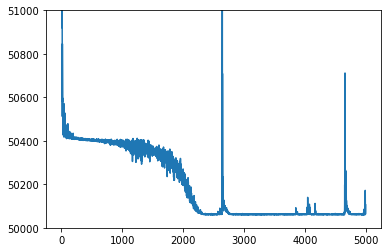

In [29]:
from matplotlib import pyplot as plt
plt.plot(cost_history)
plt.ylim(50000, 51000)

The real advantage of the SVB approach is the flexibility - as well as losing the restriction to conjugate priors, it is also much easier to implement more advanced types of parameters and priors, for example global parameters or spatial regularization priors. While these can (and have been) incorporated into the analytic VB framework, they require update equations to be re-derived whereas the SVB method simply needs an expression for the cost which is generally more straightforward.

Some things you might like to try with this example:

 - Do not infer the covariance between the parameters (see commented out code in the definition of the posterior)
 - Modify the number of samples and the learning rate and see how they affect the convergence
 
